In [1]:
from nilearn import datasets, image, plotting
import numpy as np
import nibabel as nib

julich_ontology_l = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'julich_ontology_l.xml',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_l_N10_nlin2Stdicbm152asym2009c_publicDOI_3f6407380a69007a54f5e13f3c1ba2e6.xml',
            {'move': 'julich_ontology_l.xml'}
        )
    ]
)[0]

julich_ontology_r = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'julich_ontology_r.xml',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.xml',
            {'move': 'julich_ontology_r.xml'}
        )
    ]
)[0]

ontology = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'jubrain-ontology_22.json',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/jubrain-ontology_22.json',
            {'move': 'jubrain-ontology_22.json'}
        )
    ]
)[0]

def parse_region(elem, id_2_num, father=None, triples=[]):
    name = elem['name']
    if 'labelIndex' in elem:
        if elem['labelIndex'] is not None:
            index = int(elem['labelIndex'])
            if index in id_2_num:
                num = id_2_num[index]
                triples.append((name, num))
            else:
                print(f'Este no esta: {index, name}')
        
    for c in elem['children']:
        parse_region(c, id_2_num, father=name, triples=triples)
        
    return triples


import json
import pandas as pd
import xml.etree.ElementTree as ET

tree = ET.parse(julich_ontology_l)

id_2_num = {}
for a in tree.iter():
    if a.tag == 'Structure':
        num = int(a.attrib['grayvalue'])
        id_ = int(a.attrib['id'])
        id_2_num[id_] = num

tree = ET.parse(julich_ontology_r)

for a in tree.iter():
    if a.tag == 'Structure':
        num = int(a.attrib['grayvalue'])
        id_ = int(a.attrib['id'])
        id_2_num[id_] = num


with open(ontology) as f:
    data = json.load(f)

regions = data['properties']['regions']
for elem in regions:
    triples = parse_region(elem, id_2_num)
    
    for n, r in [
        (13, 'GapMap Frontal-I (GapMap)'),
        (32, 'GapMap Frontal-to-Occipital (GapMap)'),
        (59, 'GapMap Temporal-to-Parietal (GapMap)'),
        (89, 'GapMap Frontal-II (GapMap)'),
        (95, 'GapMap Frontal-to-Temporal (GapMap)')
    ]:
        triples.append((r, n))
        
    f.close()   
    regions = pd.DataFrame(triples, columns=['r_name', 'r_number']).astype({'r_number': 'int32'}).sort_values('r_number')
    regions.drop_duplicates(inplace=True)

Este no esta: (237, 'IF (Amygdala)')


In [2]:
regions2 = regions.copy()
regions2['r_number'] = regions2['r_number'] + 1000
regions2['hemis'] = 'l'
regions['hemis'] = 'r'

regions = pd.concat((regions, regions2))

In [3]:
wb22_l = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich'),
    [
        (
            'wb22_l.nii.gz',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_l_N10_nlin2Stdicbm152asym2009c_publicDOI_3f6407380a69007a54f5e13f3c1ba2e6.nii.gz',
            {'move': 'wb22_l.nii.gz'}
        )
    ]
)[0]

wb22_r = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich'),
    [
        (
            'wb22_r.nii.gz',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.nii.gz',
            {'move': 'wb22_r.nii.gz'}
        )
    ]
)[0]

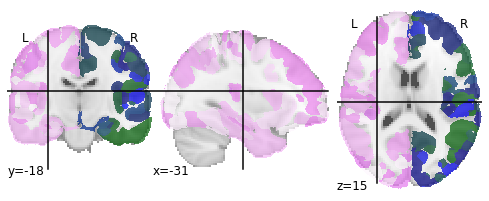

In [4]:
img_r = image.load_img(wb22_r)
img_l = image.load_img(wb22_l)
img_l_data = img_l.get_fdata()
img_r_data = img_r.get_fdata()
img_l_unmaskes = np.nonzero(img_l_data)

for v in zip(*img_l_unmaskes):
    value = img_l_data[v[0]][v[1]][v[2]]
    ex_value = img_r_data[v[0]][v[1]][v[2]]
    if ex_value == 0:
        img_r_data[v[0]][v[1]][v[2]] = value + 1000
    
conc_img = nib.spatialimages.SpatialImage(img_r_data, img_r.affine)
plotting.plot_roi(conc_img)

In [5]:
mni_t1 = nib.load(datasets.fetch_icbm152_2009()['t1'])
mni_t1 = image.resample_img(mni_t1, np.eye(3) * 4)

conc_img = image.resample_img(
    conc_img, mni_t1.affine, interpolation='nearest'
)

conc_img_data = conc_img.get_fdata()
conc_img_unmaskes = np.nonzero(conc_img_data)

julich_brain = []
for v in zip(*conc_img_unmaskes):
    julich_brain.append((v[0], v[1], v[2], conc_img_data[v[0]][v[1]][v[2]]))

In [8]:
cogAt = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('CogAt'),
    [
        (
            'cogat.xml',
            'http://data.bioontology.org/ontologies/COGAT/download?'
            'apikey=8b5b7825-538d-40e0-9e9e-5ab9274a9aeb&download_format=rdf',
            {'move': 'cogat.xml'}
        )
    ]
)[0]

In [9]:
from neurolang.frontend import NeurolangPDL

nl = NeurolangPDL()
nl.load_ontology(cogAt)

j_brain = nl.add_tuple_set(
    julich_brain,
    name='julich_brain'
)

j_regions = nl.add_tuple_set(
    regions.values,
    name='julich_regions'
)

#dilated_ifg44 = nl.add_tuple_set(
#    tuple(xyz_to_jl_region),
#    name='dilated_ifg44'
#)

In [10]:
ns_database_fn, ns_features_fn = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('neurosynth'),
    [
        (
            'database.txt',
            'https://github.com/neurosynth/neurosynth-data/raw/master/current_data.tar.gz',
            {'uncompress': True}
        ),
        (
            'features.txt',
            'https://github.com/neurosynth/neurosynth-data/raw/master/current_data.tar.gz',
            {'uncompress': True}
        ),
    ]
)

ns_database = pd.read_csv(ns_database_fn, sep=f'\t')
ijk_positions = (
    np.round(nib.affines.apply_affine(
        np.linalg.inv(mni_t1.affine),
        ns_database[['x', 'y', 'z']].values.astype(float)
    )).astype(int)
)
ns_database['i'] = ijk_positions[:, 0]
ns_database['j'] = ijk_positions[:, 1]
ns_database['k'] = ijk_positions[:, 2]

ns_features = pd.read_csv(ns_features_fn, sep=f'\t')
ns_docs = ns_features[['pmid']].drop_duplicates()
ns_terms = (
    pd.melt(
            ns_features,
            var_name='term', id_vars='pmid', value_name='TfIdf'
       )
    .query('TfIdf > 0')
)
ns_terms['prob'] = ns_terms.apply(lambda x: (1 / (1 + np.exp(-3000 * (x.TfIdf/100 - 0.001)))), axis=1)
ns_terms = ns_terms[['prob', 'pmid', 'term']]

activations = nl.add_tuple_set(ns_database.values, name='activations')
terms = nl.add_probabilistic_facts_from_tuples(ns_terms.itertuples(index=False), name='terms')
docs = nl.add_uniform_probabilistic_choice_over_set(
        ns_docs.values, name='docs'
)

from sklearn.model_selection import KFold
kfold = KFold(n_splits=20, shuffle=True, random_state=42)

ns_doc_folds = pd.concat(
    ns_docs.iloc[train].assign(fold=[i] * len(train))
    for i, (train, _) in enumerate(kfold.split(ns_docs))
)
doc_folds = nl.add_tuple_set(ns_doc_folds, name='doc_folds')

from rdflib import RDFS

part_of = nl.new_symbol(name='http://www.obofoundry.org/ro/ro.owl#part_of')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))
label = nl.new_symbol(name=str(RDFS.label))
hasTopConcept = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#hasTopConcept')

In [11]:
from typing import Iterable

@nl.add_symbol
def word_lower(name: str) -> str:
    return name.lower()

@nl.add_symbol
def mean(iterable: Iterable) -> float:
    return np.mean(iterable)


@nl.add_symbol
def std(iterable: Iterable) -> float:
    return np.std(iterable)

# Query for regions

In [13]:
#References:
#['GapMap Frontal-I (GapMap)', 13],
#['GapMap Frontal-I (GapMap)', 1013],

#['GapMap Frontal-II (GapMap)', 89],
#['GapMap Frontal-II (GapMap)', 1089],

#['CM (Amygdala)', 43],
#['VTM (Amygdala)', 79],
#['LB (Amygdala)', 90],
#['MF (Amygdala)', 103],
#['SF (Amygdala)', 109],
#['CM (Amygdala)', 1043],
#['VTM (Amygdala)', 1079],
#['LB (Amygdala)', 1090],
#['MF (Amygdala)', 1103],
#['SF (Amygdala)', 1109],

#['Area Id7 (Insula)',105],
#['Area Id7 (Insula)',1105],

### DMPC - GapMap Frontal-I (GapMap)

In [18]:
with nl.scope as e:
    
    e.ontology_terms[e.onto_name] = (
        hasTopConcept[e.uri, e.cp] &
        label[e.uri, e.onto_name]
    )

    e.filtered_terms[e.lower_name] = (
        e.ontology_terms[e.term] &
        (e.lower_name == word_lower[e.term])
    )

    e.filtered_regions[e.d, e.i, e.j, e.k] = (
        e.julich_brain[e.i, e.j, e.k, 13] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )
    
    e.filtered_regions[e.d, e.i, e.j, e.k] = (
        e.julich_brain[e.i, e.j, e.k, 1013] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )

    e.term_prob[e.t, e.fold, e.PROB[e.t, e.fold]] = (
        (e.terms[e.d, e.t] & e.docs[e.d] & 
         e.doc_folds[e.d, e.fold] & e.filtered_terms(e.t))
        // (
            e.docs[e.d] &
            e.filtered_regions[e.d, e.i, e.j, e.k]
        )
    )
    
    e.result_mean[e.term, e.mean(e.PROB)] = (
        e.term_prob[e.term, e.fold, e.PROB]    
    )

    e.result_std[e.term, e.std(e.PROB)] = (
        e.term_prob[e.term, e.fold, e.PROB]
    )
    
    e.result_summary_stats[
        e.term, e.prob_mean, e.prob_std
    ] = (
        e.result_mean[e.term, e.prob_mean] &
        e.result_std[e.term, e.prob_std]
    )

    res = nl.solve_all()

In [19]:
result_summary_stats = res['result_summary_stats']._container.copy()
thr = np.percentile(result_summary_stats['prob_mean'], 95)
sel_terms = (
    result_summary_stats
    .query('prob_mean >= @thr')
    .reset_index()
    .term
    .unique()
)
results_summary_stats_thr = (
    result_summary_stats
    .query('term in @sel_terms')
    .reset_index()
    .sort_values(['prob_mean'], ascending=False)
)
results_summary_stats_thr

,index,term,prob_mean,prob_std
4,67,memory,0.121193,0.001081
5,93,retrieval,0.054869,0.000597
0,7,attention,0.050987,0.000765
6,123,working memory,0.049622,0.000914
3,60,learning,0.049105,0.000636
1,32,encoding,0.045492,0.000507
2,58,language,0.044438,0.000708


### LFC - GapMap Frontal-II (GapMap)

In [23]:
with nl.scope as e:
    
    e.ontology_terms[e.onto_name] = (
        hasTopConcept[e.uri, e.cp] &
        label[e.uri, e.onto_name]
    )

    e.filtered_terms[e.lower_name] = (
        e.ontology_terms[e.term] &
        (e.lower_name == word_lower[e.term])
    )

    e.filtered_regions[e.d, e.i, e.j, e.k] = (
        e.julich_brain[e.i, e.j, e.k, 89] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )
    
    e.filtered_regions[e.d, e.i, e.j, e.k] = (
        e.julich_brain[e.i, e.j, e.k, 1089] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )

    e.term_prob[e.t, e.fold, e.PROB[e.t, e.fold]] = (
        (e.terms[e.d, e.t] & e.docs[e.d] & 
         e.doc_folds[e.d, e.fold] & e.filtered_terms(e.t))
        // (
            e.docs[e.d] &
            e.filtered_regions[e.d, e.i, e.j, e.k]
        )
    )
    
    e.result_mean[e.term, e.mean(e.PROB)] = (
        e.term_prob[e.term, e.fold, e.PROB]    
    )

    e.result_std[e.term, e.std(e.PROB)] = (
        e.term_prob[e.term, e.fold, e.PROB]
    )
    
    e.result_summary_stats[
        e.term, e.prob_mean, e.prob_std
    ] = (
        e.result_mean[e.term, e.prob_mean] &
        e.result_std[e.term, e.prob_std]
    )

    res = nl.solve_all()

In [24]:
result_summary_stats = res['result_summary_stats']._container.copy()
thr = np.percentile(result_summary_stats['prob_mean'], 95)
sel_terms = (
    result_summary_stats
    .query('prob_mean >= @thr')
    .reset_index()
    .term
    .unique()
)
results_summary_stats_thr = (
    result_summary_stats
    .query('term in @sel_terms')
    .reset_index()
    .sort_values(['prob_mean'], ascending=False)
)
results_summary_stats_thr

,index,term,prob_mean,prob_std
4,67,memory,0.104999,0.001359
2,58,language,0.065160,0.000823
1,7,attention,0.061630,0.001031
0,0,action,0.050346,0.000843
6,123,working memory,0.049513,0.001085
3,60,learning,0.048224,0.000935
5,93,retrieval,0.045109,0.000585


## FI - Area Id7 (Insula)

In [25]:
with nl.scope as e:
    
    e.ontology_terms[e.onto_name] = (
        hasTopConcept[e.uri, e.cp] &
        label[e.uri, e.onto_name]
    )

    e.filtered_terms[e.lower_name] = (
        e.ontology_terms[e.term] &
        (e.lower_name == word_lower[e.term])
    )

    e.filtered_regions[e.d, e.i, e.j, e.k] = (
        e.julich_brain[e.i, e.j, e.k, 105] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )
    
    e.filtered_regions[e.d, e.i, e.j, e.k] = (
        e.julich_brain[e.i, e.j, e.k, 1105] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )

    e.term_prob[e.t, e.fold, e.PROB[e.t, e.fold]] = (
        (e.terms[e.d, e.t] & e.docs[e.d] & 
         e.doc_folds[e.d, e.fold] & e.filtered_terms(e.t))
        // (
            e.docs[e.d] &
            e.filtered_regions[e.d, e.i, e.j, e.k]
        )
    )
    
    e.result_mean[e.term, e.mean(e.PROB)] = (
        e.term_prob[e.term, e.fold, e.PROB]    
    )

    e.result_std[e.term, e.std(e.PROB)] = (
        e.term_prob[e.term, e.fold, e.PROB]
    )
    
    e.result_summary_stats[
        e.term, e.prob_mean, e.prob_std
    ] = (
        e.result_mean[e.term, e.prob_mean] &
        e.result_std[e.term, e.prob_std]
    )

    res = nl.solve_all()

In [26]:
result_summary_stats = res['result_summary_stats']._container.copy()
thr = np.percentile(result_summary_stats['prob_mean'], 95)
sel_terms = (
    result_summary_stats
    .query('prob_mean >= @thr')
    .reset_index()
    .term
    .unique()
)
results_summary_stats_thr = (
    result_summary_stats
    .query('term in @sel_terms')
    .reset_index()
    .sort_values(['prob_mean'], ascending=False)
)
results_summary_stats_thr

,index,term,prob_mean,prob_std
4,67,memory,0.089854,0.001621
1,7,attention,0.066152,0.001937
3,60,learning,0.052044,0.001421
2,58,language,0.048490,0.001620
0,0,action,0.046828,0.001111
6,123,working memory,0.045905,0.001229
5,80,perception,0.045724,0.001584


## Amygdala 

In [27]:
#['CM (Amygdala)', 43],
#['VTM (Amygdala)', 79],
#['LB (Amygdala)', 90],
#['MF (Amygdala)', 103],
#['SF (Amygdala)', 109],
#['CM (Amygdala)', 1043],
#['VTM (Amygdala)', 1079],
#['LB (Amygdala)', 1090],
#['MF (Amygdala)', 1103],
#['SF (Amygdala)', 1109],

In [37]:
with nl.scope as e:
    
    e.ontology_terms[e.onto_name] = (
        hasTopConcept[e.uri, e.cp] &
        label[e.uri, e.onto_name]
    )

    e.filtered_terms[e.lower_name] = (
        e.ontology_terms[e.term] &
        (e.lower_name == word_lower[e.term])
    )

    e.filtered_regions[e.d, e.i, e.j, e.k] = (
        e.julich_brain[e.i, e.j, e.k, 43] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )
    
    e.filtered_regions[e.d, e.i, e.j, e.k] = (
        e.julich_brain[e.i, e.j, e.k, 1043] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )
    
    #e.filtered_regions[e.d, e.i, e.j, e.k] = (
    #    e.julich_brain[e.i, e.j, e.k, 79] &
    #    e.activations[
    #        e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
    #        ..., ..., ..., e.i, e.j, e.k
    #    ]
    #)
    
    #e.filtered_regions[e.d, e.i, e.j, e.k] = (
    #    e.julich_brain[e.i, e.j, e.k, 1079] &
    #    e.activations[
    #        e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
    #        ..., ..., ..., e.i, e.j, e.k
    #    ]
    #)
    
    #e.filtered_regions[e.d, e.i, e.j, e.k] = (
    #    e.julich_brain[e.i, e.j, e.k, 90] &
    #    e.activations[
    #        e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
    #        ..., ..., ..., e.i, e.j, e.k
    #    ]
    #)
    
    #e.filtered_regions[e.d, e.i, e.j, e.k] = (
    #    e.julich_brain[e.i, e.j, e.k, 1090] &
    #    e.activations[
    #        e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
    #        ..., ..., ..., e.i, e.j, e.k
    #    ]
    #)
    
    #e.filtered_regions[e.d, e.i, e.j, e.k] = (
    #    e.julich_brain[e.i, e.j, e.k, 103] &
    #    e.activations[
    #        e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
    #        ..., ..., ..., e.i, e.j, e.k
    #    ]
    #)
    
    #e.filtered_regions[e.d, e.i, e.j, e.k] = (
    #    e.julich_brain[e.i, e.j, e.k, 1103] &
    #    e.activations[
    #        e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
    #        ..., ..., ..., e.i, e.j, e.k
    #    ]
    #)
    
    #e.filtered_regions[e.d, e.i, e.j, e.k] = (
    #    e.julich_brain[e.i, e.j, e.k, 109] &
    #    e.activations[
    #        e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
    #        ..., ..., ..., e.i, e.j, e.k
    #    ]
    #)
    
    #e.filtered_regions[e.d, e.i, e.j, e.k] = (
    #    e.julich_brain[e.i, e.j, e.k, 1109] &
    #    e.activations[
    #        e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
    #        ..., ..., ..., e.i, e.j, e.k
    #    ]
    #)

    e.term_prob[e.t, e.fold, e.PROB[e.t, e.fold]] = (
        (e.terms[e.d, e.t] & e.docs[e.d] & 
         e.doc_folds[e.d, e.fold] & e.filtered_terms(e.t))
        // (
            e.docs[e.d] &
            e.filtered_regions[e.d, e.i, e.j, e.k]
        )
    )
    
    e.result_mean[e.term, e.mean(e.PROB)] = (
        e.term_prob[e.term, e.fold, e.PROB]    
    )

    e.result_std[e.term, e.std(e.PROB)] = (
        e.term_prob[e.term, e.fold, e.PROB]
    )
    
    e.result_summary_stats[
        e.term, e.prob_mean, e.prob_std
    ] = (
        e.result_mean[e.term, e.prob_mean] &
        e.result_std[e.term, e.prob_std]
    )

    res = nl.solve_all()

In [38]:
result_summary_stats = res['result_summary_stats']._container.copy()
thr = np.percentile(result_summary_stats['prob_mean'], 95)
sel_terms = (
    result_summary_stats
    .query('prob_mean >= @thr')
    .reset_index()
    .term
    .unique()
)
results_summary_stats_thr = (
    result_summary_stats
    .query('term in @sel_terms')
    .reset_index()
    .sort_values(['prob_mean'], ascending=False)
)
results_summary_stats_thr

,index,term,prob_mean,prob_std
1,23,emotion,0.128530,0.005704
4,59,memory,0.079843,0.003262
3,34,fear,0.073562,0.004216
0,4,anxiety,0.068234,0.004349
2,26,encoding,0.056103,0.002801
